# Figure 8: Milky Way Analogues (MW-ness Analysis)

This notebook generates a figure showing Milky Way-ness (MW-ness) analysis across UMAP space.

MW-ness weights are calculated using a weighted chi-squared distribution:
$$\gamma = \exp\left(-\frac{\chi^2}{2}\right) / P(M_*, {\rm SFR})$$

where:
$$\chi^2 = \left(\frac{M_*^{\mathrm{sim}} - M_*^{\mathrm{MW}}}{\sigma_{M_*}}\right)^2 + \left(\frac{\mathrm{SFR}^{\mathrm{sim}} - \mathrm{SFR}^{\mathrm{MW}}}{\sigma_{\mathrm{SFR}}}\right)^2$$

and the denominator is the distribution of SM and SFR across the suite of simulations.

The figure shows:
- **Panel 1**: MW-ness weights as scatter plot across UMAP space
- **Panel 2**: Effective Sample Size (ESS) per grid cell
- **Panel 3**: Average SFHs for populated grid cells

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import Normalize
import sys
import pickle
import cmasher as cmr

# Add src to path
sys.path.append('../src')

from utils.analysis import (sim_name, boxing, 
                           calc_pdf, calc_weights)
from utils.data_processing import get_milky_way_values
from utils.plotting import (draw_grid_C, plot_points, plot_averages)

# LaTeX font setup
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib inline

## Load Data and MW Reference Values

In [2]:
# Load processed simulation data
with open('../data/sim_data_processed.pkl', 'rb') as f:
    sim_data = pickle.load(f)

# Load UMAP embeddings
combined_labels = np.load('../data/combined_labels.npy')
embedding = np.load('../data/umap_embedding.npy')
combined_sfh = np.load('../data/combined_sfh.npy')

# Reconstruct UMAP embeddings by simulation
for i, sim in enumerate(sim_name):
    if sim_data[sim] is not None:
        sim_mask = combined_labels == i
        sim_data[sim]['umap'] = embedding[sim_mask]

print("Reconstructed UMAP data by simulation:")
for sim in sim_name:
    if sim_data[sim] is not None:
        print(f"{sim:>15s}: {sim_data[sim]['umap'].shape[0]:>8,d} galaxies")

Reconstructed UMAP data by simulation:
          EAGLE:    7,445 galaxies
      Illustris:   19,354 galaxies
   IllustrisTNG:   12,220 galaxies
         Mufasa:    1,900 galaxies
          Simba:    1,982 galaxies
         SC-SAM:   12,821 galaxies
UniverseMachine:    7,361 galaxies


In [3]:
# Get Milky Way reference values from utils function
mw_values = get_milky_way_values()
SM_MW = mw_values['stellar_mass']
dSM = mw_values['stellar_mass_error']
SFR_MW = mw_values['sfr']
dSFR = mw_values['sfr_error']

print("Milky Way reference values:")
print(f"Stellar Mass: {SM_MW:.2e} ± {dSM:.2e} M☉")
print(f"Star Formation Rate: {SFR_MW:.2f} ± {dSFR:.2f} M☉/yr")

Milky Way reference values:
Stellar Mass: 6.08e+10 ± 1.14e+10 M☉
Star Formation Rate: 1.65 ± 0.19 M☉/yr


## Create Grid and Extract z=0 Properties

In [4]:
# Create result array with UMAP coordinates and labels
result = np.column_stack((embedding, combined_labels))

# Create battleship grid structure
umaps = boxing(result[:,0], result[:,1], result)

print("Created battleship grid (10x10):")
non_empty_cells = sum(1 for i in range(10) for j in range(10) if umaps[i,j].shape[0] > 0)
print(f"  Non-empty grid cells: {non_empty_cells}/100")

# Calculate average SFH percentiles per grid cell
avg_sfh = boxing(x=embedding[:,0], y=embedding[:,1], z=combined_sfh, q=[16,50,84])

print(f"\nCalculated average SFHs per cell: shape {avg_sfh.shape}")

Created battleship grid (10x10):
  Non-empty grid cells: 69/100

Calculated average SFHs per cell: shape (10, 10, 3, 136)


In [5]:
# Extract z=0 stellar masses and SFRs
sm0_list = []
sfr0_list = []

for sim in sim_name:
    if sim_data[sim] is not None:
        # Get z=0 stellar mass
        sm0_sim = sim_data[sim]['sm']
        sm0_list.append(sm0_sim)
        
        # Get z=0 SFR (last time bin of SFH)
        sfr0_sim = sim_data[sim]['sfh_raw'][:, -1]  # Last time bin
        sfr0_list.append(sfr0_sim)

# Concatenate all simulations
sm0 = np.hstack(sm0_list)
sfr0 = np.hstack(sfr0_list)

print(f"Combined z=0 properties:")
print(f"  Stellar masses: {len(sm0):,} galaxies")
print(f"  SFRs: {len(sfr0):,} galaxies")
print(f"  SM range: {np.min(sm0):.2e} - {np.max(sm0):.2e} M☉")
print(f"  SFR range: {np.min(sfr0):.3f} - {np.max(sfr0):.3f} M☉/yr")

Combined z=0 properties:
  Stellar masses: 63,083 galaxies
  SFRs: 63,083 galaxies
  SM range: 1.00e+09 - 3.72e+12 M☉
  SFR range: 0.000 - 79.485 M☉/yr


## Calculate MW-ness Weights

In [6]:
# Calculate PDF for MW-ness correction
print("Calculating PDF for MW-ness correction...")
mwa_pdf = calc_pdf(data1=np.append(sm0, SM_MW), 
                   data2=np.append(sfr0, SFR_MW))

print(f"PDF calculated for {len(mwa_pdf)} points")

# Calculate MW-ness weights
print("Calculating MW-ness weights...")
mwa_wts, mwa_ess = calc_weights(data1=sm0, mu1=SM_MW, sigma1=dSM, 
                               data2=sfr0, mu2=SFR_MW, sigma2=dSFR, 
                               correct=True, pdf=mwa_pdf[:-1])

# Normalize by MW probability
mwa_wts /= (1/mwa_pdf[-1])

print(f"MW-ness weights calculated:")
print(f"  Range: {np.min(mwa_wts):.6f} - {np.max(mwa_wts):.6f}")
print(f"  Mean: {np.mean(mwa_wts):.6f}")
print(f"  Effective sample size: {mwa_ess:.1f}")

Calculating PDF for MW-ness correction...


c:\Users\joshs\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:266: RuntimeWarning: divide by zero encountered in log10
  logged_data = np.log10(np.c_[data1, data2].T)


PDF calculated for 63084 points
Calculating MW-ness weights...
MW-ness weights calculated:
  Range: 0.000000 - 1.004489
  Mean: 0.002611
  Effective sample size: 352.0


In [7]:
# Calculate ESS per grid cell using boxing with ess=True
print("Calculating effective sample size per grid cell...")
mwa_box = boxing(x=embedding[:,0], y=embedding[:,1], z=mwa_wts, ess=True)

print(f"ESS calculated for 10x10 grid:")
print(f"  ESS range: {np.nanmin(mwa_box):.1f} - {np.nanmax(mwa_box):.1f}")
print(f"  Mean ESS: {np.nanmean(mwa_box):.1f}")

# Count non-zero cells
non_zero_ess = np.sum(~np.isnan(mwa_box.astype(float)) & (mwa_box > 0))
print(f"  Non-zero ESS cells: {non_zero_ess}/100")

Calculating effective sample size per grid cell...
ESS calculated for 10x10 grid:
  ESS range: 1.0 - 23.9
  Mean ESS: 6.1
  Non-zero ESS cells: 69/100


c:\Users\joshs\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:114: RuntimeWarning: invalid value encountered in scalar divide
  box = np.sum(box) ** 2 / np.sum(box**2)
C:\Users\joshs\AppData\Local\Temp\ipykernel_32288\924320196.py:10: RuntimeWarning: invalid value encountered in greater
  non_zero_ess = np.sum(~np.isnan(mwa_box.astype(float)) & (mwa_box > 0))


## Generate Three-Panel MW-ness Figure

Panel 1 (MW-ness scatter) completed


C:\Users\joshs\AppData\Local\Temp\ipykernel_32288\3070601790.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


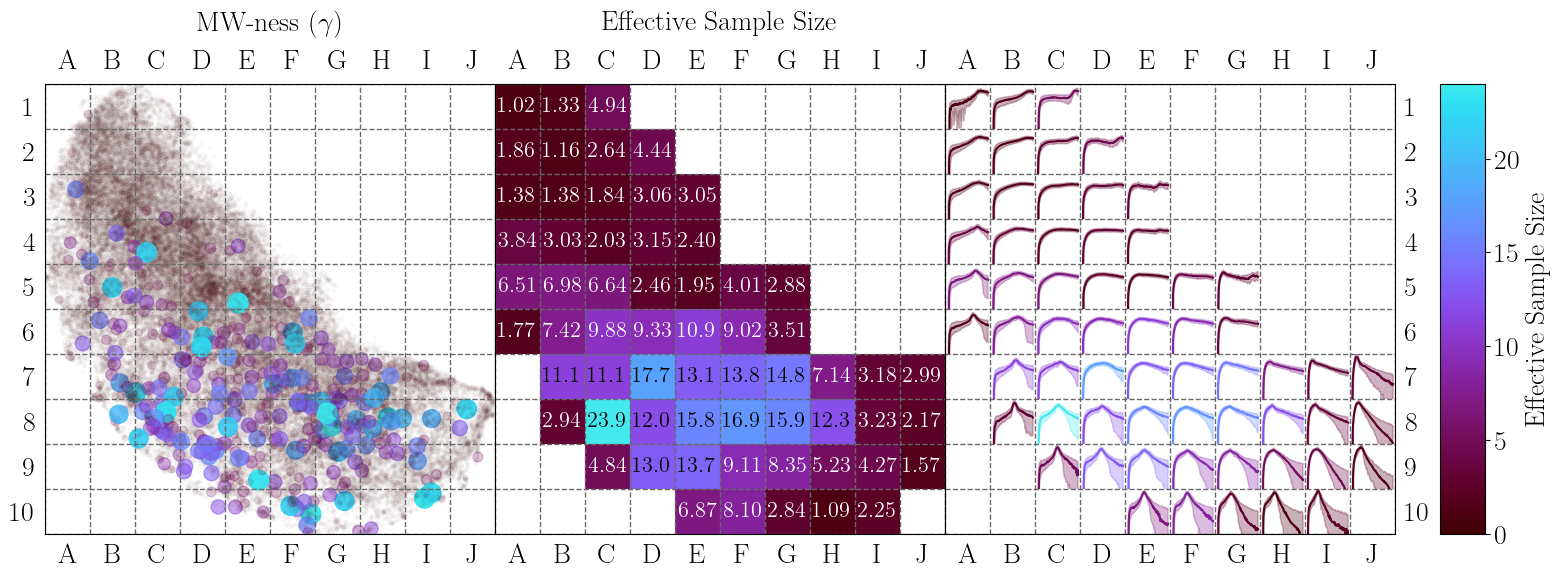

MW-ness figure generated successfully!


In [12]:
# Set up the MW-ness figure using draw_grid_C (following established pattern)
cmap = cmr.gem
fig, ax, norm = draw_grid_C(cmap, 0, np.ceil(np.nanmax(mwa_box)))

# Panel 1: MW-ness scatter plot with size and alpha scaling
sizes = 20 * (10 * mwa_wts + 3e-1)
alphas = (mwa_wts + 0.02) / np.max(mwa_wts + 0.02)

plot_points(x=embedding[:, 0], y=embedding[:, 1], z=mwa_wts, 
           fig=fig, ax=ax[0], cax=None, 
           cmap=cmap, 
           norm=Normalize(vmin=0, vmax=np.max(mwa_wts)),
           s=sizes, alpha=alphas)

ax[0].set_title('MW-ness $(\\gamma)$', fontsize=20, y=1.10)

print("Panel 1 (MW-ness scatter) completed")

# Panel 2 & 3: ESS and Average SFHs using plot_averages
plot_averages(avg=mwa_box, avg_sfh=avg_sfh, fig=fig, ax1=ax[1], ax2=ax[2], 
              cax=ax[-1], umaps=umaps, cmap=cmap, norm=norm, label='Effective Sample Size')

# Set titles
ax[1].set_title('Effective Sample Size', fontsize=20, y=1.10)

plt.tight_layout()

# Save figure
plt.savefig('../figures/milky_way_analogues.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/milky_way_analogues.pdf', bbox_inches='tight')

plt.show()

print("MW-ness figure generated successfully!")